In [1]:
%matplotlib inline
import heapq
import matplotlib.pyplot as plt
import numpy as np

from ipywidgets import widgets
from IPython.display import display
from ipywidgets import interact

## Widget layout and functionality for input

In [2]:
class signal_input():
    def __init__(self,
                 ts=1,  # sec
                 fin50=True,
                 fin50_amp=1,
                 fin70=False,
                 fin70_amp=1,
                 fs=1000,  # Hz
                 noise=0,
                 padd=False,
                ):
        header_layout = {'width':'400px', 'min_width':'400px', 'height':'28px', 'min_height':'28px'}
        text_style = {'description_width': 'initial'}
        text_layout = {'width':'50px', 'min_width':'50px'}

        
        ts_label = widgets.Button(description='Signal length [seconds]',
                                  disabled=True,
                                  button_style='',
                                  tooltip='',
                                  icon='',
                                  layout=header_layout)
        self.ts_text = widgets.Text(value=str(ts),
                                    placeholder='Signal length [s]',
                                    disabled=False,
                                    layout=text_layout,
                                    style=text_style)
        
        noise_label = widgets.Button(description='Amplitude of added noise',
                                     disabled=True,
                                     button_style='',
                                     tooltip='',
                                     icon='',
                                     layout=header_layout)
        self.noise = widgets.Text(value=str(noise),
                                  placeholder='Additive noise',
                                  disabled=False,
                                  layout=text_layout,
                                  style=text_style)

        fin_label = widgets.Button(description='Signal frequency',
                                   disabled=True,
                                   button_style='',
                                   tooltip='',
                                   icon='',
                                   layout=header_layout)
        self.fin50 = widgets.Checkbox(value=fin50,
                                      description='50 Hz',
                                      disabled=False,
                                      indent=False)        
        self.fin50_text = widgets.Text(value=str(fin50_amp),
                                       placeholder='Amplitude (0 < x < 1)',
                                       disabled=False,
                                       layout=text_layout,
                                       style=text_style)
        fin50_label = widgets.Button(description='Signal amplitude (0 < x < 1)',
                                     disabled=True,
                                     button_style='',
                                     tooltip='',
                                     icon='',
                                     layout=header_layout)
        
        self.fin70 = widgets.Checkbox(value=fin70,
                                      description='70 Hz',
                                      disabled=False,
                                      indent=False) 
        self.fin70_text = widgets.Text(value=str(fin70_amp),
                                       placeholder='Amplitude (0 < x < 1)',
                                       disabled=False,
                                       layout=text_layout,
                                       style=text_style)
        fin70_label = widgets.Button(description='Signal amplitude (0 < x < 1)',
                                     disabled=True,
                                     button_style='',
                                     tooltip='',
                                     icon='',
                                     layout=header_layout)

        padd_label = widgets.Button(description='Padd signal for FFT calculation',
                                    disabled=True,
                                    button_style='',
                                    tooltip='',
                                    icon='',
                                    layout=header_layout)
        self.padd = widgets.Checkbox(value=padd,
                                     description='Apply padding',
                                     disabled=False,
                                     indent=False)        

        fs_label = widgets.Button(description='Samples per seconds [Hz]',
                                  disabled=True,
                                  button_style='',
                                  tooltip='',
                                  icon='',
                                  layout=header_layout)
        self.fs = widgets.IntSlider(value=fs,
                                    min=100,
                                    max=3000,
                                    step=10,
                                    disabled=False,
                                    continuous_update=False,
                                    orientation='horizontal',
                                    readout=True,
                                    readout_format='d') 
        
        self.generate_plot = widgets.Button(description='Generate plot',
                                            layout={'width':'auto'})

        texts =  widgets.HBox([ts_label, self.ts_text])
        fin50 = widgets.HBox([self.fin50, self.fin50_text, fin50_label])
        fin70 = widgets.HBox([self.fin70, self.fin70_text, fin70_label])
        fin = widgets.HBox([fin_label, widgets.VBox([fin50, fin70])])
        noise = widgets.HBox([noise_label, self.noise])
        padding = widgets.HBox([padd_label, self.padd])
        fs = widgets.HBox([fs_label, self.fs])
        self.ui = widgets.VBox([texts, noise, fin, padding, fs, self.generate_plot])

## FFT functionality

In [3]:
def generateSine(fs,             # sampling frequency [Hz]
                 fin,            # signal frequency [Hz]
                 amplitude=[1.], # amplitude
                 time=0.,        # signal generation time [sec]
                 noise=0.):      # amplitude of additive white noise
    # simulate time vector
    t = np.arange(0, time, 1./fs) # [s]

    fin = np.array(fin)
    a = np.array(amplitude)
    if len(amplitude) != len(fin):
        if len(amplitude) == 1:
            a = np.ones(fin.shape)
        if len(amplitude) > len(fin):
            noise_amp = a[-1]
            a = a[:len(fin)]

    # generate signal
    signal = np.zeros(t.shape) # generate 0 vector of lenght 't'
    for i in range(0, len(fin)):
        signal = signal + amplitude[i]*np.sin(2*np.pi*fin[i]*t)

    # add white noise to the signal
    if noise > 0:
        thenoise = np.random.randn(len(t),1)
        signal = signal + thenoise.transpose().flatten()

    return [t, signal]

In [4]:
def FFT(fs,                 # sampling frequency [Hz]
        data,               # sequence to process
        withpadding=False): # add zero padding to FFT (generally only for noisy signals)
    # Remove DC components
    data = data - np.mean(data)
    # Compute the FFT of the captured signal using an algorithm for the MATLAB helpdesk
    L = len(data)
    NFFT = L
    if withpadding:
        # Get the next power of 2 from the length of the data series
        NFFT=int(2**np.ceil(np.log2(L)))

    # Now use the fft function to compute the DFT of the sequence.
    # Division by L because we want to use the fft to approximate
    # the continuous Fourier transform under the assumption
    # that the signal samples in y were taken at intervals of dt=1/L
    Fourier = np.fft.fft(data, NFFT)/L

    # All the following computation assumes that Fourier is a complex array -- ensure this assumption
    if not np.iscomplexobj(Fourier):
        # Make real array as complex with zero imaginary components
        Fourier = np.array(Fourier, dtype=np.complex)

    # Use the abs function to obtain the magnitude of the data, the angle
    # function to obtain the phase information, and unwrap to remove phase
    # jumps greater than pi to their 2*pi complement
    # Magnitude
    magnitude = 2*np.abs(Fourier[1:NFFT/2])
    # The two-sided amplitude spectrum shows half the peak amplitude at the
    # positive and half at the negative frequencies. To convert to the
    # single-sided form, multiply each frequency other than DC by two, and
    # discard the second half o the array
    # Phase
    phase = np.unwrap(np.angle(Fourier[1:NFFT/2])) # unwrapping needs to happen in radians!!

    # Frequencies corresponding to FFT
    frequencies = np.fft.fftfreq(NFFT, 1./fs)[1:NFFT/2]

    return [frequencies, magnitude, phase]

In [5]:
def displayFFT(wdgt):
    fin = []
    amplitude = []
    if wdgt.fin50.value:
        fin.append(50.)
        amplitude.append(float(wdgt.fin50_text.value))
    if wdgt.fin70.value:
        fin.append(70.)
        amplitude.append(float(wdgt.fin70_text.value))
    if len(fin) < 1:
        raise RuntimeError ('Select at least one signal frequency')
    fs = wdgt.fs.value
    ts = float(wdgt.ts_text.value)
    noise = float(wdgt.noise.value)
    padd = wdgt.padd.value
    
    msg = 'Signal = generateSine({:d}, {}, amplitude={}, time={:.1f}, noise={:.1f})'.format(
          fs, fin, amplitude, ts, noise)
    display(widgets.Label(value=msg))
    [sampletime, sinewave] = generateSine(fs, fin, amplitude=amplitude, time=ts, noise=noise)
    fig, ax = plt.subplots(nrows=1, ncols=1,
                           facecolor='white',
                           figsize=(15, 3))  # W x H
    fig.set_canvas(plt.gcf().canvas)
    plt.subplots_adjust(hspace=0,wspace=0)    
    ax.plot(sampletime, sinewave,'b')
    ax.set_ylabel('Sine Wave')
    ax.set_xlabel('Time [sec]')
    
    [spectrum, magnitude, phase] = FFT(fs, sinewave, withpadding=padd)
    if len(magnitude) > 1:
        largest2_value = heapq.nlargest(2, magnitude)
        largest2_index = map(list(magnitude).index, largest2_value)
        msg_amp = 'Amplitude spectrum = [{:4.2f}, {:4.2f}] [V]]'.format(
                  largest2_value[0], largest2_value[1])
        msg_freq = 'Fundamental frequency from FFT = [{:4.2f}, {:4.2f}] [Hz]'.format(
                   spectrum[largest2_index[0]], spectrum[largest2_index[1]])
    else:
        msg_amp = 'Amplitude spectrum = {:4.2f} [V]'.format(np.max(magnitude))
        msg_freq = 'Fundamental frequency from FFT = {:4.2f} [Hz]'.format(spectrum[np.argmax(magnitude)])

    display(widgets.Label(value=msg_amp))
    display(widgets.Label(value=msg_freq))
    fig, ax = plt.subplots(nrows=2, ncols=1,
                           facecolor='white',
                           figsize=(15, 5))  # W x H
    fig.set_canvas(plt.gcf().canvas)
    plt.subplots_adjust(hspace=0,wspace=0)        
    # amplitude spectrum = amplitude vs frequency
    # power spectrum = power vs frequency
    # power = 20*np.log10(amplitude)
    ax[0].plot(spectrum, magnitude, 'b')
    ax[0].set_ylabel('Magnitude [V]')

    # phase spectrum = phase vs frequency
    ax[1].plot(spectrum, phase, 'b')
    ax[1].set_ylabel('Phase [Deg]')
    ax[1].set_xlabel('Frequency [Hertz]')

## Generate a single frequency sinewave

Label(value=u'Signal = generateSine(1000, [50.0], amplitude=[1.0], time=0.3, noise=0.0)')

Label(value=u'Amplitude spectrum = [1.00, 0.00] [V]]')

Label(value=u'Fundamental frequency from FFT = [50.00, 63.33] [Hz]')

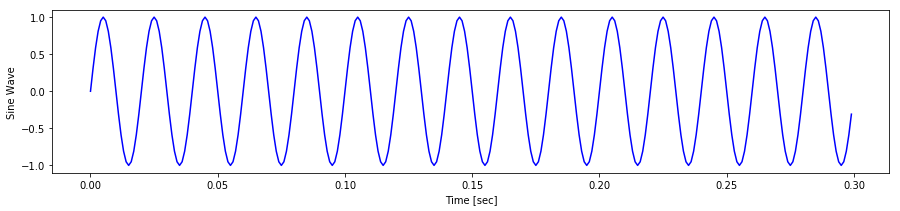

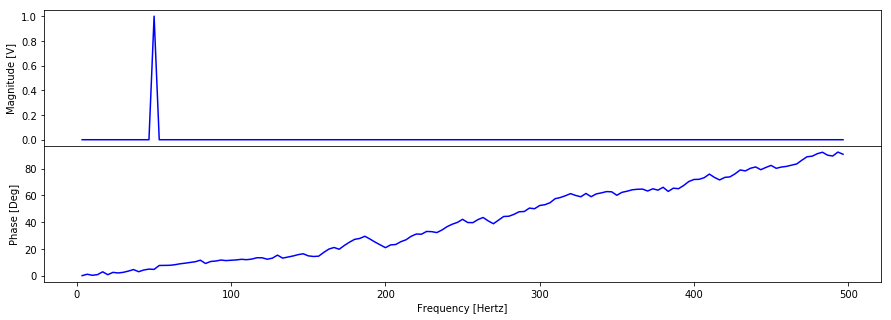

In [6]:
displayFFT(signal_input(ts=0.3))

## Generate a single frequency sinewave with noise

Label(value=u'Signal = generateSine(1000, [50.0], amplitude=[1.0], time=0.3, noise=0.2)')

Label(value=u'Amplitude spectrum = [0.94, 0.91] [V]]')

Label(value=u'Fundamental frequency from FFT = [50.78, 48.83] [Hz]')

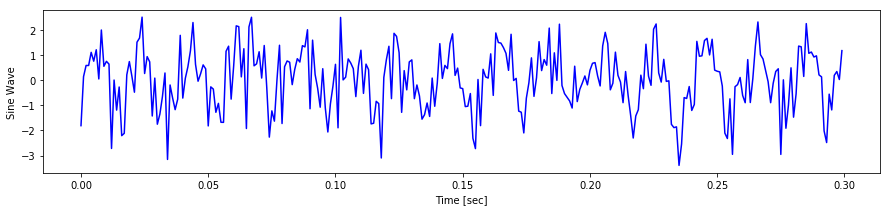

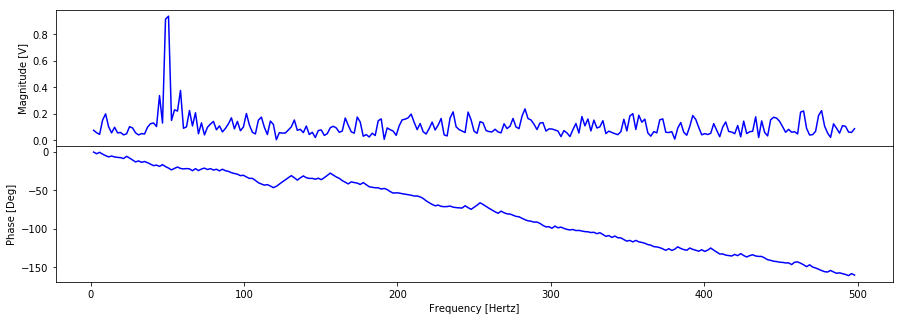

In [7]:
# Padding the FFT of a noisy signal improves the phase information
displayFFT(signal_input(ts=0.3, noise=0.2, padd=True))

## Generate a multiple frequency sinewave

Label(value=u'Signal = generateSine(1000, [50.0, 70.0], amplitude=[1.0, 0.3], time=0.3, noise=0.0)')

Label(value=u'Amplitude spectrum = [1.00, 0.30] [V]]')

Label(value=u'Fundamental frequency from FFT = [50.00, 70.00] [Hz]')

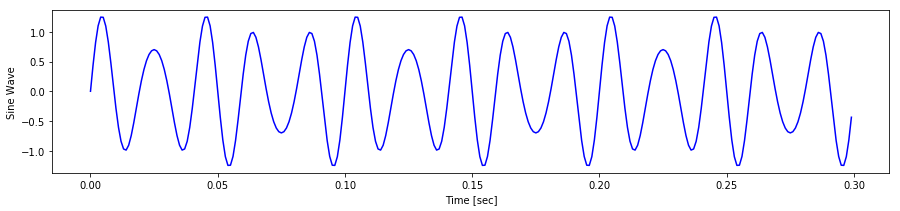

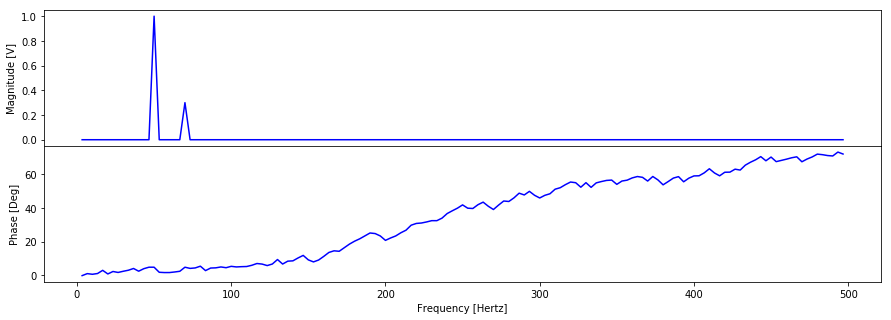

In [8]:
displayFFT(signal_input(ts=0.3, fin50=True, fin50_amp=1, fin70=True, fin70_amp=0.3))

## Generate a multiple frequency sinewave with noise

Label(value=u'Signal = generateSine(1000, [50.0, 70.0], amplitude=[1.0, 0.3], time=0.3, noise=0.2)')

Label(value=u'Amplitude spectrum = [1.04, 0.99] [V]]')

Label(value=u'Fundamental frequency from FFT = [50.78, 48.83] [Hz]')

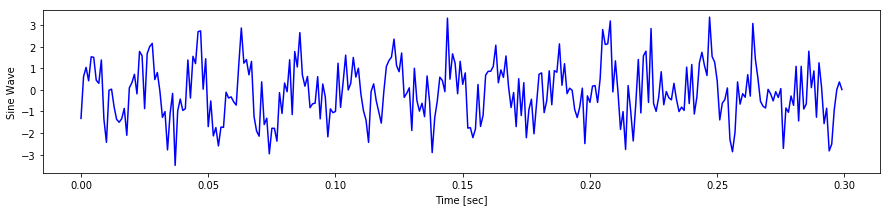

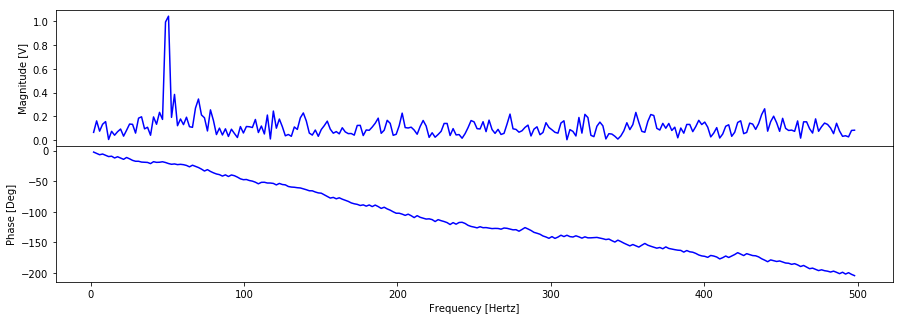

In [9]:
displayFFT(signal_input(ts=0.3, fin50=True, fin50_amp=1, fin70=True, fin70_amp=0.3, noise=0.2, padd=True))

## Generate your own signal

In [10]:
from IPython.display import clear_output
input_ = signal_input()
display(input_.ui)

def on_button_clicked(b):
    clear_output(wait=True)
    display(input_.ui)
    displayFFT(input_)

input_.generate_plot.on_click(on_button_clicked)

VkJveChjaGlsZHJlbj0oSEJveChjaGlsZHJlbj0oQnV0dG9uKGRlc2NyaXB0aW9uPXUnU2lnbmFsIGxlbmd0aCBbc2Vjb25kc10nLCBkaXNhYmxlZD1UcnVlLCBsYXlvdXQ9TGF5b3V0KGhlaWfigKY=
